# Non-linear Breit-Wheeler pair creation

In [125]:
import math as m
import numpy as np

electron_mass = 9.10938356e-31
elementary_charge = 1.6021766208e-19
speed_of_light = 299792458
reduced_plank = 1.054571800e-34
vacuum_permittivity =  8.854187817e-12
fine_structure_constant =  0.0072973525664

classical_elec_radius = (1./4./np.pi/vacuum_permittivity)*( elementary_charge**2 / (electron_mass * speed_of_light**2))

lambda_laser = 1.0e-6

schwinger_field_SI = electron_mass**2 * speed_of_light**3 / (reduced_plank*elementary_charge)

schwinger_field_code_units = electron_mass*speed_of_light*lambda_laser/(2.0*reduced_plank*m.pi)

conversion_of_rate_from_code_to_SI = (2.0 * m.pi * speed_of_light)/lambda_laser

conversion_of_rate_from_SI_to_code = 1.0/conversion_of_rate_from_code_to_SI

field_reference_PIC = 2.0 * np.pi * electron_mass * speed_of_light * speed_of_light / (elementary_charge*lambda_laser)

def calc_chi_gamma(p, E, B):
    gamma_phot = np.linalg.norm(p)  
    c = p/gamma_phot  
    loc_field = gamma_phot * np.linalg.norm( E - np.dot(c,E)*c + np.cross(c,B))     
    return loc_field/schwinger_field_code_units

import scipy.special as spe
import scipy.integrate as integ

def inner(x):
    return integ.quad(lambda s: np.sqrt(s)*spe.kv(1./3., 2./3. * s**(3./2.)), x, np.inf)[0] 

inner = np.vectorize(inner)

def X(chi_phot, chi_ele):
    if (chi_phot > chi_ele and chi_ele != 0):
        return np.power(chi_phot/(chi_ele*(chi_phot-chi_ele)), 2./3.)        
    else:
        return 1.0e30

X = np.vectorize(X)

def T(chi_phot):
    coeff = 1./(np.pi * np.sqrt(3.) * chi_phot * chi_phot)
    return integ.quad(lambda chi_ele: 
                      coeff*(inner(X(chi_phot, chi_ele)) - 
                      (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.)) )
                      , 0, chi_phot)[0] 
T = np.vectorize(T)
    
def dNBW_dt(chi_phot, e_phot):
    val = ((electron_mass*(speed_of_light)**2)*fine_structure_constant/reduced_plank)*(chi_phot/e_phot)*T(chi_phot)
    return val

px = np.logspace(-1, 8.0, num=100, base=10)

def ff(px):
    return dNBW_dt(calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0])), px)

ff = np.vectorize(ff)

def cc(px):
    return calc_chi_gamma(np.array([px,0,0]),np.array([0,500,0]),np.array([0,0,0]))

cc = np.vectorize(cc)


10.918396060976502 747700780427416.0 0.747700780427416
8.221420749918629
3.754220692020846
1.4218771771440866
7.192292270129815e-91
0.0
chi:22.13432485042229
1.4642899997686907


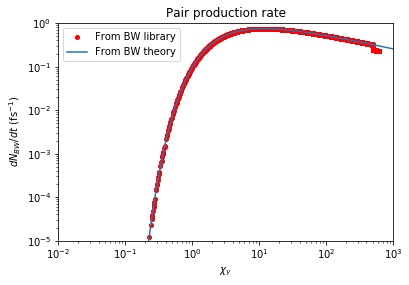

In [119]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('bw_rate.dat', delimiter=' ', unpack=True)
plt.loglog(x,y, 'ro', label='From BW library', markersize=4)
plt.loglog(cc(px), ff(px)*1e-15, label='From BW theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{BW}/dt$ (fs$^{-1}$)')
plt.title('Pair production rate')
plt.legend()
plt.ylim(1e-5, 1)
plt.xlim(1e-2,1e3)
plt.show()

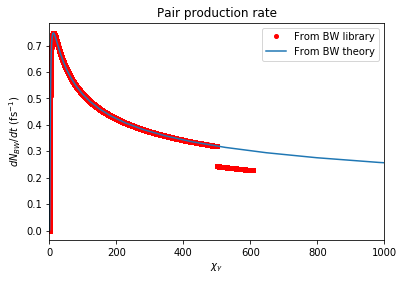

In [23]:
import matplotlib.pyplot as plt
import numpy as np

x, y = np.loadtxt('bw_rate.dat', delimiter=' ', unpack=True)
plt.plot(x,y, 'ro', label='From BW library', markersize=4)
plt.plot(cc(px), ff(px)*1e-15, label='From BW theory')

plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$dN_{BW}/dt$ (fs$^{-1}$)')
plt.title('Pair production rate')
plt.legend()
plt.xlim(1e-2,1e3)
plt.show()

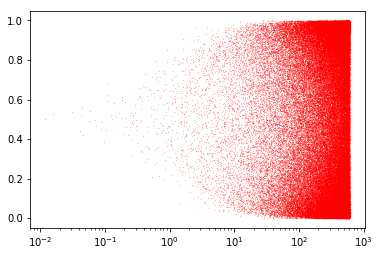

In [126]:
x, ye = np.loadtxt('bw_pairs.dat', delimiter=' ', unpack=True, usecols=(0,1))
pairs = zip(x, ye)
sel = [pps for pps in pairs if pps[1] <= 1.0]
x,ye = zip(*sel)
xedges = np.linspace(0, 600.0, num=100)
yedges = np.linspace(0.0, 1.0, num=20)
H, xedges, yedges = np.histogram2d(x, ye, bins=(xedges, yedges))
H = H.T
XX, YY = np.meshgrid(xedges, yedges)
#plt.pcolormesh(X, Y, H)
plt.semilogx(x,ye,'ro', markersize=0.1)
plt.show()

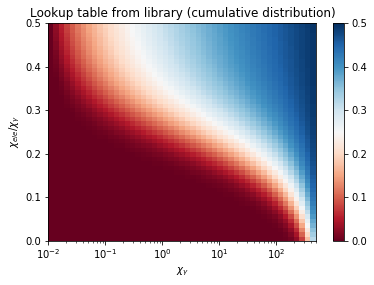

In [135]:
chilen = 50
fraclen = 50
chi, frac, prob = np.loadtxt('cum_prob_tab.dat', delimiter=' ', unpack=True, usecols=(0,1,2))
chi = np.exp(chi)
chi = chi[0::chilen]
frac = frac[0:fraclen]
prob = prob.reshape(chilen, fraclen)
CHI, FRAC = np.meshgrid(chi, frac)
plt.xscale("log")
p = plt.pcolor(CHI, FRAC, prob, cmap=plt.cm.RdBu, vmin=abs(prob).min(), vmax=abs(prob).max())
plt.title("Lookup table from library (cumulative distribution)")
plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$\chi_{ele}/\chi_{\gamma}$ ')
cb = plt.colorbar(p)

In [131]:
def num(chi_phot, chi_part):
    coeff = 1./(np.pi * np.sqrt(3.) * chi_phot * chi_phot)
    return integ.quad(lambda chi_ele: 
                      coeff*(inner(X(chi_phot, chi_ele)) - 
                      (2.0 - chi_phot*np.power(X(chi_phot, chi_ele), 3./2.))*spe.kv(2./3., 2./3. *X(chi_phot, chi_ele)**(3./2.)) )
                      , 0, chi_part)[0] 

num = np.vectorize(num)

def P(chi_phot, frac):
    print(str(chi_phot) + " " + str(frac))
    return num(chi_phot, frac*chi_phot)/T(chi_phot)


pairs = zip(CHI.ravel(), FRAC.ravel())


PP = [P(pa[0], pa[1]) for pa in pairs]

PP = np.reshape(PP, (chilen, fraclen)).T


p = plt.pcolor(CHI, FRAC, P(CHI, FRAC), cmap=plt.cm.RdBu, vmin=abs(prob).min(), vmax=abs(prob).max())
cb = plt.colorbar(p)


0.010000001859881084 0.0
0.012470866935682721 0.0
0.01555224932021702 0.0
0.019395193526025062 0.0
0.024187483266903093 0.0
0.030163882922936543 0.0
0.0376169700232363 0.0
0.0469116140433322 0.0
0.05850283876641773 0.0
0.07295882777686079 0.0
0.0909859663765545 0.0
0.1134673668660704 0.0
0.14150361705491574 0.0
0.17646724510015666 0.0
0.22007211299479584 0.0
0.27444895269702146 0.0
0.342261573315621 0.0
0.4268297744163901 0.0
0.5322946976814721 0.0
0.6638188387096964 0.0
0.8278411424071341 0.0
1.0323912361357368 0.0
1.287482807411758 0.0
1.6056055899061445 0.0
2.0023329985433986 0.0
2.4970873683182457 0.0
3.114099420982712 0.0
3.883551228061853 0.0
4.843124159543158 0.0
6.039794571335324 0.0
7.532146040908572 0.0
9.393331287442784 0.0
11.71429627812861 0.0
14.60874029591855 0.0
18.218362244435905 0.0
22.71987290801643 0.0
28.333645913428363 0.0
35.33485957394257 0.0
44.065624998085006 0.0
54.953644358156865 0.0
68.53194589601353 0.0
85.46526191573682 0.0
106.58363690539166 0.0
132.9190

132.91901061547077 0.0510204
165.76149863114594 0.0510204
206.71892080157636 0.0510204
257.7963674933806 0.0510204
321.4943597571031 0.0510204
400.9352728745692 0.0510204
500.0009507898083 0.0510204
0.010000001859881084 0.0612245
0.012470866935682721 0.0612245
0.01555224932021702 0.0612245
0.019395193526025062 0.0612245
0.024187483266903093 0.0612245
0.030163882922936543 0.0612245
0.0376169700232363 0.0612245
0.0469116140433322 0.0612245
0.05850283876641773 0.0612245
0.07295882777686079 0.0612245
0.0909859663765545 0.0612245
0.1134673668660704 0.0612245
0.14150361705491574 0.0612245
0.17646724510015666 0.0612245
0.22007211299479584 0.0612245
0.27444895269702146 0.0612245
0.342261573315621 0.0612245
0.4268297744163901 0.0612245
0.5322946976814721 0.0612245
0.6638188387096964 0.0612245
0.8278411424071341 0.0612245
1.0323912361357368 0.0612245
1.287482807411758 0.0612245
1.6056055899061445 0.0612245
2.0023329985433986 0.0612245
2.4970873683182457 0.0612245
3.114099420982712 0.0612245
3.88

6.039794571335324 0.112245
7.532146040908572 0.112245
9.393331287442784 0.112245
11.71429627812861 0.112245
14.60874029591855 0.112245
18.218362244435905 0.112245
22.71987290801643 0.112245
28.333645913428363 0.112245
35.33485957394257 0.112245
44.065624998085006 0.112245
54.953644358156865 0.112245
68.53194589601353 0.112245
85.46526191573682 0.112245
106.58363690539166 0.112245
132.91901061547077 0.112245
165.76149863114594 0.112245
206.71892080157636 0.112245
257.7963674933806 0.112245
321.4943597571031 0.112245
400.9352728745692 0.112245
500.0009507898083 0.112245
0.010000001859881084 0.122449
0.012470866935682721 0.122449
0.01555224932021702 0.122449
0.019395193526025062 0.122449
0.024187483266903093 0.122449
0.030163882922936543 0.122449
0.0376169700232363 0.122449
0.0469116140433322 0.122449
0.05850283876641773 0.122449
0.07295882777686079 0.122449
0.0909859663765545 0.122449
0.1134673668660704 0.122449
0.14150361705491574 0.122449
0.17646724510015666 0.122449
0.2200721129947958

1.287482807411758 0.173469
1.6056055899061445 0.173469
2.0023329985433986 0.173469
2.4970873683182457 0.173469
3.114099420982712 0.173469
3.883551228061853 0.173469
4.843124159543158 0.173469
6.039794571335324 0.173469
7.532146040908572 0.173469
9.393331287442784 0.173469
11.71429627812861 0.173469
14.60874029591855 0.173469
18.218362244435905 0.173469
22.71987290801643 0.173469
28.333645913428363 0.173469
35.33485957394257 0.173469
44.065624998085006 0.173469
54.953644358156865 0.173469
68.53194589601353 0.173469
85.46526191573682 0.173469
106.58363690539166 0.173469
132.91901061547077 0.173469
165.76149863114594 0.173469
206.71892080157636 0.173469
257.7963674933806 0.173469
321.4943597571031 0.173469
400.9352728745692 0.173469
500.0009507898083 0.173469
0.010000001859881084 0.183673
0.012470866935682721 0.183673
0.01555224932021702 0.183673
0.019395193526025062 0.183673
0.024187483266903093 0.183673
0.030163882922936543 0.183673
0.0376169700232363 0.183673
0.0469116140433322 0.18367

0.6638188387096964 0.234694
0.8278411424071341 0.234694
1.0323912361357368 0.234694
1.287482807411758 0.234694
1.6056055899061445 0.234694
2.0023329985433986 0.234694
2.4970873683182457 0.234694
3.114099420982712 0.234694
3.883551228061853 0.234694
4.843124159543158 0.234694
6.039794571335324 0.234694
7.532146040908572 0.234694
9.393331287442784 0.234694
11.71429627812861 0.234694
14.60874029591855 0.234694
18.218362244435905 0.234694
22.71987290801643 0.234694
28.333645913428363 0.234694
35.33485957394257 0.234694
44.065624998085006 0.234694
54.953644358156865 0.234694
68.53194589601353 0.234694
85.46526191573682 0.234694
106.58363690539166 0.234694
132.91901061547077 0.234694
165.76149863114594 0.234694
206.71892080157636 0.234694
257.7963674933806 0.234694
321.4943597571031 0.234694
400.9352728745692 0.234694
500.0009507898083 0.234694
0.010000001859881084 0.244898
0.012470866935682721 0.244898
0.01555224932021702 0.244898
0.019395193526025062 0.244898
0.024187483266903093 0.244898


0.6638188387096964 0.295918
0.8278411424071341 0.295918
1.0323912361357368 0.295918
1.287482807411758 0.295918
1.6056055899061445 0.295918
2.0023329985433986 0.295918
2.4970873683182457 0.295918
3.114099420982712 0.295918
3.883551228061853 0.295918
4.843124159543158 0.295918
6.039794571335324 0.295918
7.532146040908572 0.295918
9.393331287442784 0.295918
11.71429627812861 0.295918
14.60874029591855 0.295918
18.218362244435905 0.295918
22.71987290801643 0.295918
28.333645913428363 0.295918
35.33485957394257 0.295918
44.065624998085006 0.295918
54.953644358156865 0.295918
68.53194589601353 0.295918
85.46526191573682 0.295918
106.58363690539166 0.295918
132.91901061547077 0.295918
165.76149863114594 0.295918
206.71892080157636 0.295918
257.7963674933806 0.295918
321.4943597571031 0.295918
400.9352728745692 0.295918
500.0009507898083 0.295918
0.010000001859881084 0.306122
0.012470866935682721 0.306122
0.01555224932021702 0.306122
0.019395193526025062 0.306122
0.024187483266903093 0.306122


0.6638188387096964 0.357143
0.8278411424071341 0.357143
1.0323912361357368 0.357143
1.287482807411758 0.357143
1.6056055899061445 0.357143
2.0023329985433986 0.357143
2.4970873683182457 0.357143
3.114099420982712 0.357143
3.883551228061853 0.357143
4.843124159543158 0.357143
6.039794571335324 0.357143
7.532146040908572 0.357143
9.393331287442784 0.357143
11.71429627812861 0.357143
14.60874029591855 0.357143
18.218362244435905 0.357143
22.71987290801643 0.357143
28.333645913428363 0.357143
35.33485957394257 0.357143
44.065624998085006 0.357143
54.953644358156865 0.357143
68.53194589601353 0.357143
85.46526191573682 0.357143
106.58363690539166 0.357143
132.91901061547077 0.357143
165.76149863114594 0.357143
206.71892080157636 0.357143
257.7963674933806 0.357143
321.4943597571031 0.357143
400.9352728745692 0.357143
500.0009507898083 0.357143
0.010000001859881084 0.367347
0.012470866935682721 0.367347
0.01555224932021702 0.367347
0.019395193526025062 0.367347
0.024187483266903093 0.367347


0.6638188387096964 0.418367
0.8278411424071341 0.418367
1.0323912361357368 0.418367
1.287482807411758 0.418367
1.6056055899061445 0.418367
2.0023329985433986 0.418367
2.4970873683182457 0.418367
3.114099420982712 0.418367
3.883551228061853 0.418367
4.843124159543158 0.418367
6.039794571335324 0.418367
7.532146040908572 0.418367
9.393331287442784 0.418367
11.71429627812861 0.418367
14.60874029591855 0.418367
18.218362244435905 0.418367
22.71987290801643 0.418367
28.333645913428363 0.418367
35.33485957394257 0.418367
44.065624998085006 0.418367
54.953644358156865 0.418367
68.53194589601353 0.418367
85.46526191573682 0.418367
106.58363690539166 0.418367
132.91901061547077 0.418367
165.76149863114594 0.418367
206.71892080157636 0.418367
257.7963674933806 0.418367
321.4943597571031 0.418367
400.9352728745692 0.418367
500.0009507898083 0.418367
0.010000001859881084 0.428571
0.012470866935682721 0.428571
0.01555224932021702 0.428571
0.019395193526025062 0.428571
0.024187483266903093 0.428571


0.6638188387096964 0.479592
0.8278411424071341 0.479592
1.0323912361357368 0.479592
1.287482807411758 0.479592
1.6056055899061445 0.479592
2.0023329985433986 0.479592
2.4970873683182457 0.479592
3.114099420982712 0.479592
3.883551228061853 0.479592
4.843124159543158 0.479592
6.039794571335324 0.479592
7.532146040908572 0.479592
9.393331287442784 0.479592
11.71429627812861 0.479592
14.60874029591855 0.479592
18.218362244435905 0.479592
22.71987290801643 0.479592
28.333645913428363 0.479592
35.33485957394257 0.479592
44.065624998085006 0.479592
54.953644358156865 0.479592
68.53194589601353 0.479592
85.46526191573682 0.479592
106.58363690539166 0.479592
132.91901061547077 0.479592
165.76149863114594 0.479592
206.71892080157636 0.479592
257.7963674933806 0.479592
321.4943597571031 0.479592
400.9352728745692 0.479592
500.0009507898083 0.479592
0.010000001859881084 0.489796
0.012470866935682721 0.489796
0.01555224932021702 0.489796
0.019395193526025062 0.489796
0.024187483266903093 0.489796


KeyboardInterrupt: 

Text(0, 0.5, '$\\chi_{ele}/\\chi_{\\gamma}$ ')

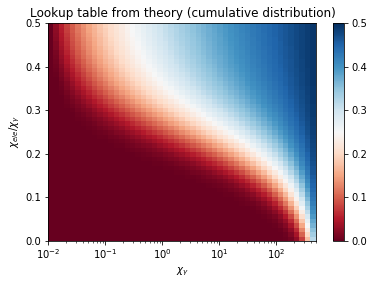

In [141]:
p = plt.pcolor(CHI, FRAC, PP, cmap=plt.cm.RdBu, vmin=abs(prob).min(), vmax=abs(prob).max())
cb = plt.colorbar(p)
plt.xscale("log")
plt.title("Lookup table from theory (cumulative distribution)")
plt.xlabel('$\chi_{\gamma}$')
plt.ylabel('$\chi_{ele}/\chi_{\gamma}$ ')

(array([   3.,    5.,   13.,   32.,   71.,   97.,  166.,  236.,  293.,
         400.,  457.,  526.,  676.,  761.,  842., 1012., 1099., 1176.,
        1272., 1375., 1452., 1564., 1536., 1660., 1721., 1799., 1876.,
        1898., 1883., 1981., 2101., 2124., 2044., 2149., 2200., 2215.,
        2142., 2252., 2171., 2257., 2232., 2248., 2276., 2235., 2182.,
        2149., 2150., 2120., 2107., 1959., 2044., 2053., 1921., 1930.,
        1848., 1777., 1673., 1551., 1557., 1456., 1340., 1282., 1185.,
        1083., 1017.,  916.,  816.,  713.,  605.,  506.,  431.,  348.,
         274.,  180.,  144.,   67.,   47.,   28.,   13.]),
 array([  92.8199    ,  109.15812911,  125.49635823,  141.83458734,
         158.17281646,  174.51104557,  190.84927468,  207.1875038 ,
         223.52573291,  239.86396203,  256.20219114,  272.54042025,
         288.87864937,  305.21687848,  321.55510759,  337.89333671,
         354.23156582,  370.56979494,  386.90802405,  403.24625316,
         419.58448228,  435.92271

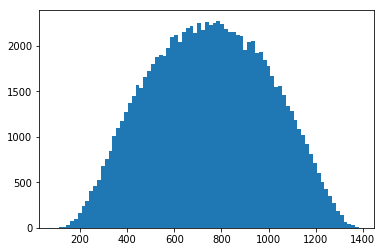

In [147]:
g_ele, g_pos = np.loadtxt('smicheck.dat', delimiter=' ', unpack=True)
plt.hist(g_ele, bins='auto')